In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
## MLP: Initializations# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# https://github.com/wagonhelm/NaNmnist/blob/master/NaNmnist.ipynb
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/neural_network.ipynb

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax, ticks,title, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
        plt.title(title)
    plt.yticks(ticks)
    fig.canvas.draw()

In [4]:
# Network Parameters
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [5]:
# x isn't a specific value. It's a placeholder, a value that we'll input when we ask TensorFlow to run a computation.
# We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. 
# We represent this as a 2-D tensor of floating-point numbers, with a shape X = [None, 784]. 
# (Here None means that a dimension can be of any length.)
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# keep_prob: we will be using these placeholders when we use dropouts, while testing model
keep_prob = tf.placeholder(tf.float32)
# keep_prob_input: we will be using these placeholders when we use dropouts, while training model
keep_prob_input = tf.placeholder(tf.float32)

In [6]:
# Weight initialization

# https://arxiv.org/pdf/1707.09725.pdf#page=95
# https://www.tensorflow.org/api_docs/python/tf/random_normal
# Outputs random values from a normal distribution mean=0 std=1

# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni+ni+1). 
# h1 =>  σ=√(2/(fan_in+fan_out+1) = 0.039  => N(0,σ) = N(0,0.039)
# h2 =>  σ=√(2/(fan_in+fan_out+1) = 0.055  => N(0,σ) = N(0,0.055)
# out =>  σ=√(2/(fan_in+fan_out+1) = 0.120  => N(0,σ) = N(0,0.120)
# SGD: Xavier/Glorot Normal initialization.
weights_sgd = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.039, mean=0)),    #784x512 # sqrt(2/(784+512)) = 0.039
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.055, mean=0)), #512x128 # sqrt(2/(512+128)) = 0.055
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}


# https://arxiv.org/pdf/1707.09725.pdf#page=95
# for relu lates
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
# h1 =>  σ=√(2/(fan_in+1) = 0.062  => N(0,σ) = N(0,0.062)
# h2 =>  σ=√(2/(fan_in+1) = 0.125  => N(0,σ) = N(0,0.125)
# out =>  σ=√(2/(fan_in+1) = 0.120  => N(0,σ) = N(0,0.120)
# He Normal initialization.
weights_relu = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1],stddev=0.062, mean=0)),    #784x512
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2],stddev=0.125, mean=0)), #512x128
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes],stddev=0.120, mean=0))  #128x10
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),             #512x1
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),             #128x1
    'out': tf.Variable(tf.random_normal([n_classes]))              #10x1
}

In [7]:
# Parameters
training_epochs = 15
learning_rate = 0.001
batch_size = 100
display_step = 1

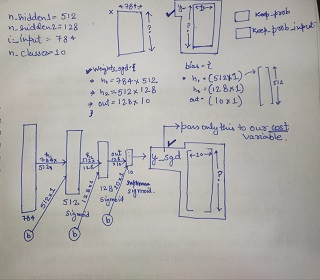

<h3> Model 1: input (784) - sigmoid(512) - sigmoid(128) - 
softmax(output 10) </h3>

In [8]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.sigmoid(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.sigmoid(layer_2)  
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())         
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 1 + AdamOptimizer __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch: 0001 train cost=1.685869597 test cost=1.679493636
Epoch: 0002 train cost=1.540462078 test cost=1.538375570
Epoch: 0003 train cost=1.517031257 test cost=1.517045223
Epoch: 0004 train cost=1.504656049 test cost=1.505915428
Epoch: 0005 train cost=1.496300693 test cost=1.498666996
Epoch: 0006 train cost=1.489777452 test cost=1.493425180
Epoch: 0007 train cost=1.485159219 test cost=1.489616241
Epoch: 0008 train cost=1.481203316 test cost=1.487201386
Epoch: 0009 train cost=1.478349809 test cost=1.485353292
Epoch: 0010 train cost=1.476177922 test cost=1.484137467
Epoch: 0011 train cost=1.474092244 test cost=1.482992358
Epoch: 0012 train cost=

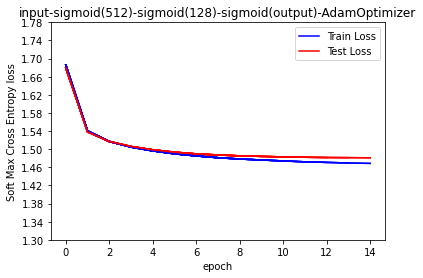

In [9]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
y_sgd = multilayer_perceptron(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_sgd = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_sgd, labels = y_))
#cost_sgd = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_sgd), reduction_indices=[1]))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_sgd)
optimizer_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_sgd)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here c: corresponds to the parameter cost_sgd
            # w : correspondse to the parameter weights_sgd
            # c = sess.run() return the cost after every bath during train
            # w = sess.run() return the weights that are modified after every batch through Back prop
            # w is dict w = {'h1': updated h1 weight vector after the current batch,
            #                'h2': updated h2 weight vector after the current batch, 
            #                'out': updated output weight vector after the current batch, 
            #                }
            # you check these w matrix for every iteration, and check whats happening during back prop
            #
            # note: sess.run() returns parameter values based on the input parameters
            # _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd]) it returns three parameters
            # _, c = sess.run([optimizer_adam, cost_sgd ]) it returns two parameters
            # _ = sess.run([optimizer_adam]) it returns one paramter (for the input optimizer it return none)
            # c = sess.run([cost_sgd]) it returns one paramter (for the input cost return error after the batch)

            # feed_dict={x: batch_xs, y_: batch_ys} here x, y_ should be placeholders
            # x, y_ are the input parameters on which the models gets trained

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_adam, cost_sgd,weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

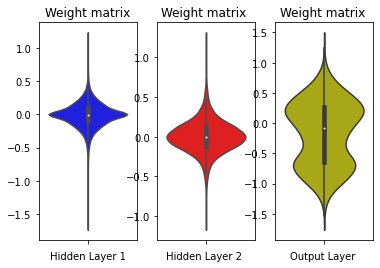

In [10]:
# Plot weight distriubtion at the end of training.

import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 1 + GradientDescentOptimizer __

Epoch: 0001 train cost=2.309515678 test cost=2.308642687
Epoch: 0002 train cost=2.307097756 test cost=2.306320555
Epoch: 0003 train cost=2.305188110 test cost=2.304490643
Epoch: 0004 train cost=2.303699190 test cost=2.303081023
Epoch: 0005 train cost=2.302533653 test cost=2.302010416
Epoch: 0006 train cost=2.301615419 test cost=2.301159049
Epoch: 0007 train cost=2.300881450 test cost=2.300456133
Epoch: 0008 train cost=2.300281079 test cost=2.299909035
Epoch: 0009 train cost=2.299776877 test cost=2.299415345
Epoch: 0010 train cost=2.299342690 test cost=2.299004436
Epoch: 0011 train cost=2.298955348 test cost=2.298633012
Epoch: 0012 train cost=2.298600626 test cost=2.298289672
Epoch: 0013 train cost=2.298267547 test cost=2.297976813
Epoch: 0014 train cost=2.297951006 test cost=2.297663010
Epoch: 0015 train cost=2.297644198 test cost=2.297364941
Accuracy: 0.1135


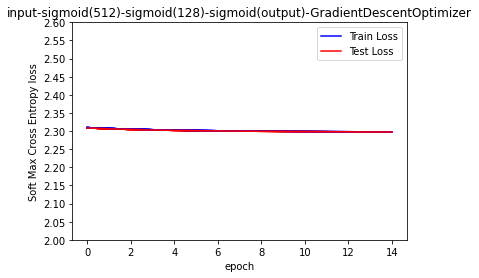

In [11]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables.

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_sgdc, cost_sgd, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_sgd, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(2, 2.6, step=0.05), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(2, 2.6, step=0.05), "input-sigmoid(512)-sigmoid(128)-sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(y_sgd,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

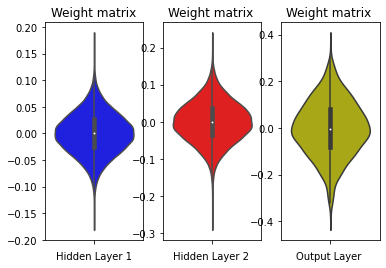

In [12]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 2: input (784) - ReLu(512) - ReLu(128) - sigmoid(output 10) </h3>

In [13]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_relu(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    # Hidden layer with ReLu activation
    # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Input-ReLu(512)-ReLu(128)-sigmoid(output) - AdamOptimizer  __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.562865136 test cost=1.557589257
Epoch: 0002 train cost=1.499059015 test cost=1.499487357
Epoch: 0003 train cost=1.487503521 test cost=1.490990361
Epoch: 0004 train cost=1.480911998 test cost=1.486219287
Epoch: 0005 train cost=1.477497655 test cost=1.484275892
Epoch: 0006 train cost=1.474713514 test cost=1.482956562
Epoch: 0007 train cost=1.473084196 test cost=1.482115589
Epoch: 0008 train cost=1.471492409 test cost=1.481443205
Epoch: 0009 train cost=1.470183629 test cost=1.480891620
Epoch: 0010 train cost=1.469548332 test cost=1.480089456
Epoch: 0011 train cost=1.468549698 test cost=1.480186160
Epoch: 0012 train cost=1.467971094 test cost=1.480156750
Epoch: 0013 train cost=1.467676545 test cost=1.479967005
Epoch: 0014 train cost=1.467075249 test cost=1.479439203
Epoch: 0015 train cost=1.466471244 test cos

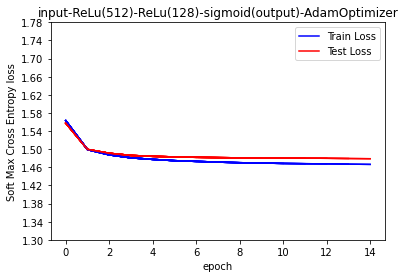

In [14]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
yrelu = multilayer_perceptron_relu(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_relu = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = yrelu, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_relu_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_relu)
optimizer_relu_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_relu)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_relu_adam, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-ReLu(512)-ReLu(128)-sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.3, 1.8, step=0.04), "input-ReLu(512)-ReLu(128)-sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

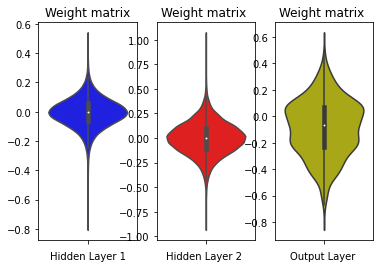

In [15]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__Input-ReLu(512)-ReLu(128)-sigmoid(output) - GradientDescentOptimizer__

Epoch: 0001 train cost=2.299361385 test cost=2.300608188
Epoch: 0002 train cost=2.221843206 test cost=2.219641306
Epoch: 0003 train cost=2.128713933 test cost=2.124138878
Epoch: 0004 train cost=2.046701767 test cost=2.040753774
Epoch: 0005 train cost=1.975526870 test cost=1.968459229
Epoch: 0006 train cost=1.913355557 test cost=1.905740297
Epoch: 0007 train cost=1.874449464 test cost=1.866642943
Epoch: 0008 train cost=1.844428853 test cost=1.836664136
Epoch: 0009 train cost=1.820354046 test cost=1.812594177
Epoch: 0010 train cost=1.800643549 test cost=1.792970122
Epoch: 0011 train cost=1.784239852 test cost=1.776658495
Epoch: 0012 train cost=1.770374691 test cost=1.762818950
Epoch: 0013 train cost=1.758441838 test cost=1.750950872
Epoch: 0014 train cost=1.748066110 test cost=1.740554934
Epoch: 0015 train cost=1.738887307 test cost=1.731452829
Accuracy: 0.8134


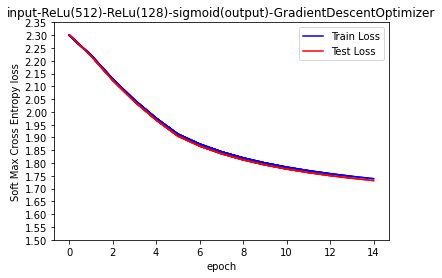

In [16]:
# We can now launch the model in an InteractiveSession

# We first have to create an operation to initialize the variables we created:
# https://github.com/amitmac/Question-Answering/issues/2

# Note: make sure you initialize variables after AdamOptimizer

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_relu_sgdc, cost_relu, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_relu, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-ReLu(512)-ReLu(128)-sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-ReLu(512)-ReLu(128)-sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(yrelu,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

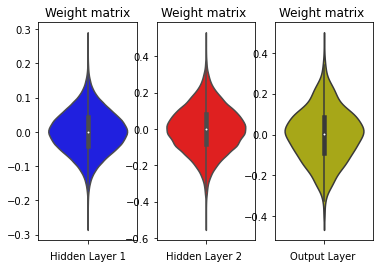

In [17]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 3: Input - Sigmoid(BatchNormalization(512)) - Sigmoid(BatchNormalization(128))- Sigmoid(output) </h3>

In [18]:
# https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
# https://r2rt.com/implementing-batch-normalization-in-tensorflow.html
epsilon = 1e-3
def multilayer_perceptron_batch(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    
    ############################################################
    # Hidden layer with Sigmoid activation and batch normalization
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_1, batch_var_1 = tf.nn.moments(layer_1,[0])
    
    scale_1 = tf.Variable(tf.ones([n_hidden_1]))
    beta_1 = tf.Variable(tf.zeros([n_hidden_1]))
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
    layer_1 = tf.nn.batch_normalization(layer_1, batch_mean_1, batch_var_1, beta_1, scale_1, epsilon)
    layer_1 = tf.nn.sigmoid(layer_1)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    #####################################################################################
    
    # Hidden layer with Sigmoid activation and batch normalization
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    
    # https://www.tensorflow.org/api_docs/python/tf/nn/moments
    # Calculate the mean and variance of x.
    batch_mean_2, batch_var_2 = tf.nn.moments(layer_2, [0])
    
    scale_2 = tf.Variable(tf.ones([n_hidden_2]))
    beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
    
    layer_2 = tf.nn.batch_normalization(layer_2, batch_mean_2, batch_var_2, beta_2, scale_2, epsilon)
    layer_2 = tf.nn.sigmoid(layer_2)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    ######################################################################################
    
    # output layer with Sigmoid activation 
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 3+ AdamOptimizer  __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.698439414 test cost=1.690054947
Epoch: 0002 train cost=1.553945360 test cost=1.550272913
Epoch: 0003 train cost=1.516161788 test cost=1.514969943
Epoch: 0004 train cost=1.499850583 test cost=1.501823502
Epoch: 0005 train cost=1.491212536 test cost=1.494519810
Epoch: 0006 train cost=1.485548255 test cost=1.491114244
Epoch: 0007 train cost=1.482393527 test cost=1.488432966
Epoch: 0008 train cost=1.479475861 test cost=1.486249081
Epoch: 0009 train cost=1.477120404 test cost=1.485037528
Epoch: 0010 train cost=1.475378696 test cost=1.483781895
Epoch: 0011 train cost=1.474200477 test cost=1.483644664
Epoch: 0012 train cost=1.472489418 test cost=1.482381844
Epoch: 0013 train cost=1.472115203 test cost=1.482385081
Epoch: 0014 train cost=1.470197559 test cost=1.481670710
Epoch: 0015 train cost=1.469963027 test cos

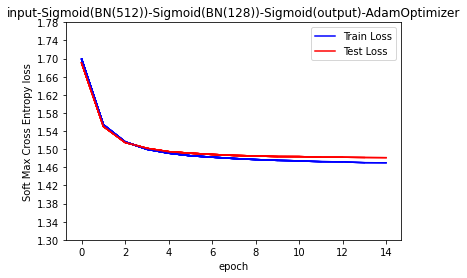

In [19]:
# Since we are using sigmoid activations in hiden layers we will be using weights that are initalized as weights_sgd
ybatch = multilayer_perceptron_batch(x, weights_sgd, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_batch = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ybatch, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_batch_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_batch)
optimizer_batch_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_batch)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_batch_adam, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.3, 1.8, step=0.04), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

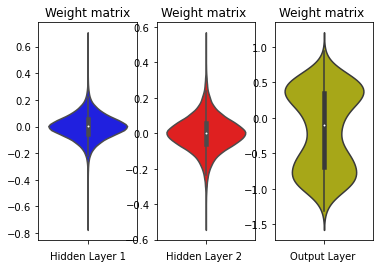

In [20]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

__ Model 3 + GradientDescentOptimizer  __

Epoch: 0001 train cost=2.318892291 test cost=2.317913361
Epoch: 0002 train cost=2.280796973 test cost=2.278599264
Epoch: 0003 train cost=2.244727178 test cost=2.241437939
Epoch: 0004 train cost=2.212607050 test cost=2.208577131
Epoch: 0005 train cost=2.184277491 test cost=2.179643155
Epoch: 0006 train cost=2.158724365 test cost=2.153537621
Epoch: 0007 train cost=2.134969930 test cost=2.129511920
Epoch: 0008 train cost=2.112863240 test cost=2.107126038
Epoch: 0009 train cost=2.092507407 test cost=2.086363358
Epoch: 0010 train cost=2.073600619 test cost=2.067418492
Epoch: 0011 train cost=2.056810191 test cost=2.050594442
Epoch: 0012 train cost=2.042135243 test cost=2.035787548
Epoch: 0013 train cost=2.029234083 test cost=2.022846987
Epoch: 0014 train cost=2.017977968 test cost=2.011358069
Epoch: 0015 train cost=2.007590939 test cost=2.001035399
Accuracy: 0.7956


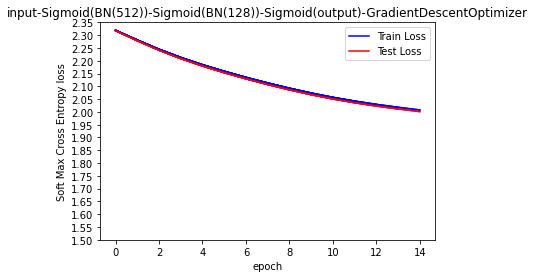

In [21]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)

            # here we use GradientDescentOptimizer
            _, c, w = sess.run([optimizer_batch_sgdc, cost_batch, weights_sgd], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_batch, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1.5, 2.4, step=0.05), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-GradientDescentOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax, np.arange(1.5, 2.4, step=0.05), "input-Sigmoid(BN(512))-Sigmoid(BN(128))-Sigmoid(output)-GradientDescentOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ybatch,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels}))

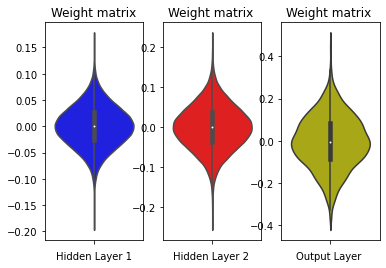

In [22]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
plt.show()

<h3> Model 4: Input - ReLu(512) - Dropout - ReLu(128)- Dropout -Sigmoid(output) </h3>

In [23]:
# https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/multi_layer_perceptron_mnist.html
# Create model
def multilayer_perceptron_dropout(x, weights, biases):
    # Use tf.matmul instead of "*" because tf.matmul can change it's dimensions on the fly (broadcast)
    print( 'x:', x.get_shape(), 'W[h1]:', weights['h1'].get_shape(), 'b[h1]:', biases['b1'].get_shape())        
    # we are adding a drop out layer after input layers with parameter keep_prob_input
    
    # Hidden layer with ReLu activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1']) #(x*weights['h1']) + biases['b1']
    layer_1 = tf.nn.relu(layer_1)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_1_drop = tf.nn.dropout(layer_1, keep_prob)
    
    print( 'layer_1:', layer_1.get_shape(), 'W[h2]:', weights['h2'].get_shape(), 'b[h2]:', biases['b2'].get_shape())        
    
    # Hidden layer with ReLu activation
    layer_2 = tf.add(tf.matmul(layer_1_drop, weights['h2']), biases['b2']) # (layer_1 * weights['h2']) + biases['b2'] 
    layer_2 = tf.nn.relu(layer_2)
    # we are adding a drop out layer after the first hidden layer with parameter keep_prob
    layer_2_drop = tf.nn.dropout(layer_2, keep_prob)
    print( 'layer_2:', layer_2.get_shape(), 'W[out]:', weights['out'].get_shape(), 'b3:', biases['out'].get_shape())        
    
    # Output layer with Sigmoid activation
    out_layer = tf.matmul(layer_2_drop, weights['out']) + biases['out'] # (layer_2 * weights['out']) + biases['out']    
    out_layer = tf.nn.sigmoid(out_layer)
    print('out_layer:',out_layer.get_shape())

    return out_layer

__ Model 4 + AdamOptimizer __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=1.675873031 test cost=1.598223528
Epoch: 0002 train cost=1.546355459 test cost=1.513368575
Epoch: 0003 train cost=1.525626282 test cost=1.502317007
Epoch: 0004 train cost=1.514386814 test cost=1.496008073
Epoch: 0005 train cost=1.507560452 test cost=1.491636782
Epoch: 0006 train cost=1.503062506 test cost=1.488905478
Epoch: 0007 train cost=1.499840188 test cost=1.487168550
Epoch: 0008 train cost=1.496941187 test cost=1.485498719
Epoch: 0009 train cost=1.494317583 test cost=1.484662520
Epoch: 0010 train cost=1.491876932 test cost=1.483507610
Epoch: 0011 train cost=1.490457490 test cost=1.482883643
Epoch: 0012 train cost=1.488893890 test cost=1.482015948
Epoch: 0013 train cost=1.488438378 test co

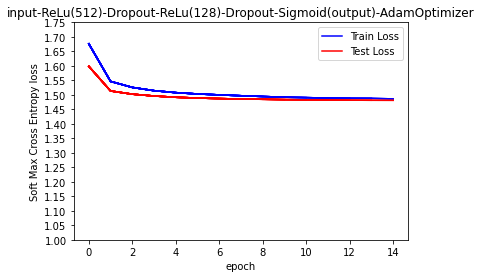

In [24]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))

Text(0.5, 0, 'Output Layer ')

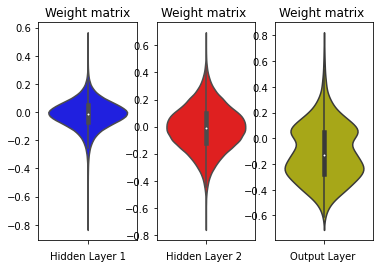

In [25]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()

__ Model 4 + GradientDescentOptimizer __

x: (?, 784) W[h1]: (784, 512) b[h1]: (512,)
layer_1: (?, 512) W[h2]: (512, 128) b[h2]: (128,)
layer_2: (?, 128) W[out]: (128, 10) b3: (10,)
out_layer: (?, 10)
Epoch: 0001 train cost=2.365624882 test cost=2.314861531
Epoch: 0002 train cost=2.345548177 test cost=2.272078368
Epoch: 0003 train cost=2.329621623 test cost=2.239909022
Epoch: 0004 train cost=2.314011989 test cost=2.216253024
Epoch: 0005 train cost=2.295956893 test cost=2.193912735
Epoch: 0006 train cost=2.283102210 test cost=2.169232714
Epoch: 0007 train cost=2.270247495 test cost=2.141362355
Epoch: 0008 train cost=2.254499489 test cost=2.109108927
Epoch: 0009 train cost=2.239043909 test cost=2.078043434
Epoch: 0010 train cost=2.225459430 test cost=2.050452628
Epoch: 0011 train cost=2.207288446 test cost=2.023931515
Epoch: 0012 train cost=2.194939224 test cost=1.997812686
Epoch: 0013 train cost=2.175900963 test cost=1.972535473
Epoch: 0014 train cost=2.164103226 test cost=1.948490734
Epoch: 0015 train cost=2.148036853 test cos

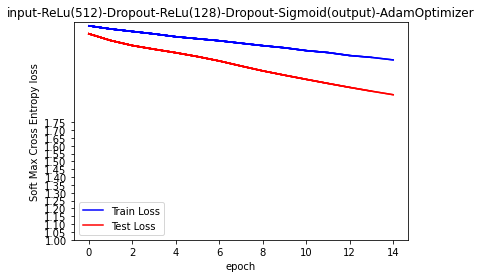

In [26]:
# Since we are using Relu activations in hiden layers we will be using weights that are initalized as weights_relu
ydrop = multilayer_perceptron_dropout(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)

        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_sgdc, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels,  keep_prob: 1.0})
            test_avg_cost += c / total_batch

        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))

Text(0.5, 0, 'Output Layer ')

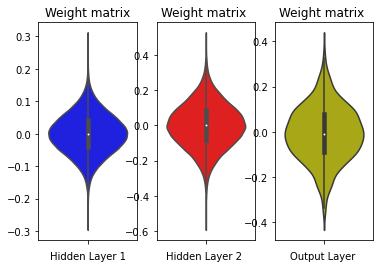

In [27]:
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')
# plt.show()